# EEL4511 Real-time DSP Applications Lab 9 Final Project

### Samuel Cuervo

### Git Repo: https://github.com/scuervo101/TI-F28379D-SPEECH-RECOGNITION

## Abstract:
Using the codec and the DSP, I will be sampling voice triggered audio and attempting to recognize what word is spoken from a set of pre-trained words. The DSP will communicate back to the user using UART and the serial console on the computer. The voice recognition engine uses MFCC, a Hamming window filter on which FFT and mel spectrum transform is applied to extract a smaller set of descriptive features, and uses a KNN model as a classification tool for determining the label (which word) the audio sample belongs to.

# UPDATES FROM PART 1

## Mel Spectrum data

I found attempting to implement MFCC from scratch was too difficult and would take a long time to process on the DSP. During testing, I found that converting the data to a Mel Spectrum would give a high accuracy (90% give or take) and could be implement on the DSP much easier. The only problem with taking the mel Spectrum is that the DSP may still take a long time to process the information.

## KNN

I will still be using KNN. I have given the DSP a constant float array with the training data preprocessed through the Mel Spectrum

# TI-F28379D-SPEECH-RECOGNITION

## DSP Speech Recognition

### Notes

- Planning on using KNN for the classification and MFCC feature extraction for the audio files
- MFCC uses FFT feature extraction
- Extracting from wav files and a test set provided by me using the microphone on the codec
- Not sure how many test files will be needed, planning on doing 20-30 per word
- Planning on using the TensorFlow Command Speech data set for training
- Another possiblity is to run an FFT on the data and test its pitch (yes high pitch, no low pitch)
- Python will handle the Pre-computation of the ML model's parameters

### Functionality

The dsp will be continuously sampling the microphone. When audio is detected on the microphone (threshold is surpassed), it will begin to record the sampled data into the external SRAM. After recording the data into the SRAM, it will process the data in the background (ML processing, MFCC to KNN, or FFT). Responses from the DSP will be displayed through UART and a serial console.

Plans for the DSP to have a simple conversation with the user (with responses that illustrate the response ie. If answer no, DSP respond with "why not")

*Yes* and *No* will be the words initially featured. If the DSP can handle more, will add *Hello* and *Goodbye*

Conversation theme is about the DSP taking over the world. Answer improperly and flash the RED LEDs or answer correctly and flash the BLUE LEDs

Using the 8 bit LEDs for debugging the state.

**Logical states:** 

- Idle (listening and waiting for a signal or a response on the microphone)
- Recording (Storing the sampling data into the SRAM)
- Processing (Running ML processing or FFT(During this point either save the next signal response or don't sample))

After the processing is complete, trigger the DSPs response and send it through UART

# Python Speech Recognition Proof of Concept

Below is a test implementation of the DSP speech recognition using MFCC for feature extraction and KNN for classification

Testing the classification between yes and no

In another notebook, I will do the proper K fold testing for finding the best possible parameters 

In [477]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io  import wavfile
from librosa.feature import mfcc

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

## Data Set

I created a personal data set of the words yes and no (24 samples for each word) for the proof of concept. For the final training data, I will use the larger [TensorFlow Speech Commands](https://www.tensorflow.org/datasets/catalog/speech_commands) data set.

Below I import the data set


In [596]:
data = []
labels = []

# Read the sample data from DSP-DataSet
for i in range(24):
    print("Reading data:" + "yes_" + str(i) + ".wav")
    samplerate, wav = wavfile.read("../../DSP-DataSet/yes_ds/yes_" + str(i) + ".wav")
    data += [wav]
    labels.append(1)

    print("Reading data:" + "no_" + str(i) + ".wav")
    samplerate, wav = wavfile.read("../../DSP-DataSet/no_ds/no_" + str(i) + ".wav")
    data += [wav]
    labels.append(0)

data = np.array(data,dtype="float")
labels = np.array(labels)

Reading data:yes_0.wav
Reading data:no_0.wav
Reading data:yes_1.wav
Reading data:no_1.wav
Reading data:yes_2.wav
Reading data:no_2.wav
Reading data:yes_3.wav
Reading data:no_3.wav
Reading data:yes_4.wav
Reading data:no_4.wav
Reading data:yes_5.wav
Reading data:no_5.wav
Reading data:yes_6.wav
Reading data:no_6.wav
Reading data:yes_7.wav
Reading data:no_7.wav
Reading data:yes_8.wav
Reading data:no_8.wav
Reading data:yes_9.wav
Reading data:no_9.wav
Reading data:yes_10.wav
Reading data:no_10.wav
Reading data:yes_11.wav
Reading data:no_11.wav
Reading data:yes_12.wav
Reading data:no_12.wav
Reading data:yes_13.wav
Reading data:no_13.wav
Reading data:yes_14.wav
Reading data:no_14.wav
Reading data:yes_15.wav
Reading data:no_15.wav
Reading data:yes_16.wav
Reading data:no_16.wav
Reading data:yes_17.wav
Reading data:no_17.wav
Reading data:yes_18.wav
Reading data:no_18.wav
Reading data:yes_19.wav
Reading data:no_19.wav
Reading data:yes_20.wav
Reading data:no_20.wav
Reading data:yes_21.wav
Reading d

## MFCC Feature Extraction

In an attempt to reduce the model complexity, MFCC will extract the top 12 coefficients that describe the audio. This reduces the size of samples from 44100 elements (1 sec audio clips) to 12 elements.

The MFCC function used here is using the Librosa library. I will be creating my own MFCC function (in C) using the DSP's FFT function and by manually applying the filtering.

In [480]:
n_fft=48
n_mfcc = 13
samplerate, _ = wavfile.read("../../DSP-DataSet/yes_ds/yes_0.wav")

features = []
for i in range(data.shape[0]):
    features += [mfcc(y=data[i], sr=samplerate, n_mfcc=n_mfcc, n_fft=n_fft)]

features = np.array(features)

processed_features = np.zeros((features.shape[0], features.shape[1]))

for i in range(data.shape[0]):
    for j in range(features.shape[1]):
        mean = sum(features[i][j]) / len(features[i][j])
        processed_features[i][j] = mean

features = processed_features
processed_features.shape

(48, 13)

## KNN Parameter Training

I have to split the data set to train it with a separate group from testing. Before I can train the KNN model, I most run some form of validation to find the best parameters. I am using a sklearn function called GridSearchCV which will test parameters until it finds the best scoring set of parameters.

In [481]:
features_train, features_test, labels_train, labels_test = train_test_split(features,labels,test_size=0.15)

print(features_train.shape[1])

# Testing parameters to find the best set
params = {
    "n_neighbors" : list(range(3, 21, 2)),
    "weights" : ["uniform", "distance"],
    "metric" : ["euclidean", "manhattan", "chebyshev"]
}

GSCV = GridSearchCV(KNeighborsClassifier(), params, verbose=1, cv=3, n_jobs=-1)

13


In [482]:
results = GSCV.fit(features, labels)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   11.6s finished


In [483]:
print("The best parameters for KNN classification are: ")
print(results.best_params_)
print("\nWith a score of: " + str(results.best_score_))

The best parameters for KNN classification are: 
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}

With a score of: 0.9791666666666666


### KNN Model Training

After finding the best parameters, I will train the KNN model with the training data set and test it with the test data set. Once the model has been trained, I can extract the models weights to implement it in C for the DSP

**Note** Due to the small sample size, the model reaches perfect accuracy which could mean it is overfitting or could be inaccurate in a real world scenerio. I will be expanding the data set later.

In [484]:
knn = KNeighborsClassifier(n_neighbors=3, metric="euclidean", weights="uniform")
knn = knn.fit(features_train,labels_train)

pred = knn.predict(features_test)

print("Predicted labels for the test set: ")
print(pred)
print("Expected labels for the test set: ")
print(labels_test)

Predicted labels for the test set: 
[0 1 1 0 1 1 1 1]
Expected labels for the test set: 
[0 1 1 0 1 1 1 1]


# Mel Spectrum Raw Implementation

This will be where I write my Mel Spectrum implementation with code that will be easy to translate to C

In [453]:
# Convert from frequency to Mel scale
def hztoMel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

# Convert from Mel scale to frequency
def meltoHz(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

# Generate the uniform Mel scale bank that relates to the freq's min and max points
#       IE. Generate a uniform scale based off of max and min freq and then convert that back 
#       to frequency (which will not be uniform)
#
#       Params:
#           bin_size : The number of bins in DFT,
#           n_filters : The number of mel filters to include in the filterbank. Default is 20.
#           min_freq, max_freq : The minimum and maximum freq
#           fs : Sample rate
def mel_filterbanks(bin_size, n_filters = 20, min_freq = 0, max_freq = fs // 2, fs = 44100):

    min_mel, max_mel = hztoMel(min_freq), hztoMel(max_freq)

    # Uniformly spaced values on the mel scale
    mel_bins = np.linspace(min_mel, max_mel, n_filters + 2)

    freq_bins = meltoHz(mel_bins)

    hz_bins = np.linspace(0, fs / 2, 1 + bin_size // 2, endpoint=True)  # Double slash is floor divison, equal to division of ints

    # Find the Filterbank
    filter_bank = np.zeros((n_filters, 1 + bin_size // 2))
    ramps = []
    for i in range(freq_bins.shape[0]):
        layer = []
        for j in range(hz_bins.shape[0]):
            layer.append(freq_bins[i] - hz_bins[j])
        ramps.append(layer)
    
    ramps = np.array(ramps)

    for i in range(n_filters):
        left = -ramps[i] / (freq_bins[i + 1] - freq_bins[i])
        right = ramps[i + 2] / (freq_bins[i + 2] - freq_bins[i + 1])
    
        reduced = np.zeros(left.shape[0])
        for j in range(left.shape[0]):
            if (left[j] < right[j]) and (left[j] > 0):
                reduced[j] = left[j]
            elif (right[j] < left[j]) and (right[j] > 0):
                reduced[j] = right[j]
            else:
                reduced[j] = 0
        filter_bank[i] = reduced

    # Normalize the filter bank
    energy_norm = np.zeros(n_filters)
    for i in range(n_filters):
        energy_norm[i] = 2.0 / (freq_bins[i + 2] - freq_bins[i])

    for i in range(filter_bank.shape[0]):
        for j in range(filter_bank.shape[1]):
            filter_bank[i][j] *= energy_norm[i]

    return filter_bank

In [565]:
# Frame the signal into overlapping windows
#   
#       Params:
#           x : Signal in time domain
#           frame_width : Frame width or FFT size
#           stride : Duration length between windows
#           fs : Sample rate
def frame_audio(x, frame_width, stride, fs):
    
    n_frames = (len(x) - frame_width) // stride + 1
    frames = np.zeros((n_frames,frame_width))

    for n in range(n_frames):
        for i in range(frame_width):
            frames[n][i] = x[n*stride + i]
    
    return frames

In [580]:
# Compute the power spectrum by finding the magnitude spectrum using the absolute value of DFT and then squaring that
#       
#       Params:
#           frames : Signal separated into frames
def power_spectrum(frames):

    spectrum = np.zeros( (frames.shape[0] , (frames.shape[1] // 2) + 1), dtype = np.float64 )

    for n in range(frames.shape[0]):
        value = np.abs(np.fft.fft(frames[n])[: (frames.shape[1] // 2) + 1])
        spectrum[n] = value

    return spectrum ** 2


In [581]:
#   Mel Spectrum Helper functions
#
# Padding function that pads the array with mirrored elements
def reflect_pad(x, pad):
    y = np.zeros((2*pad + x.shape[0]))

    y_it = pad - 1
    i = x.shape[0] + 1
    size = 0
    while(size < pad):
        if ((( (x.shape[0]-1) - i) % (x.shape[0]*2)) > (x.shape[0] - 1) ) and ( (i % (x.shape[0])) != 0):
            y[y_it] = x[(i)% (x.shape[0]) ]
            size += 1
            y_it -= 1
        elif ((i% (x.shape[0]) ) != 0):
            y[y_it] = x[((x.shape[0]-1) -i) % (x.shape[0])]
            size += 1
            y_it -= 1
        i += 1

    y_it = pad
    for i in range(x.shape[0]):
        y[y_it] = x[i]
        y_it += 1

    y_it = (pad + x.shape[0])
    i = 0
    size = 0
    while(size < pad):
        if ((( (x.shape[0]-1) - i) % (x.shape[0]*2)) > (x.shape[0] - 1) ) and ( (i % (x.shape[0])) != 0):
            y[y_it] = x[(i)% (x.shape[0]) ]
            size += 1
            y_it += 1
        elif ((i% (x.shape[0]) ) != 0):
            y[y_it] = x[((x.shape[0]-1) -i) % (x.shape[0])]
            size += 1
            y_it += 1
        i += 1
    
    return y

# Matrix multiplication function
def matrix_mul(a,b):
    assert a.shape[1] == b.shape[0]

    result = np.zeros((a.shape[0],b.shape[1]))
    for i in range(a.shape[0]):
        for j in range(b.shape[1]):
            for k in range(a.shape[1]):
                result[i][j] += a[i][k] * b[k][j]
    return result

# Creates a hamming window of size len
def hamming_window(len):

    len += 1
    inputs = np.linspace(-np.pi, np.pi, len)
    window = np.zeros((len))

    for i in range(len):
        window[i] += 0.54 * np.cos(0 * inputs[i])
        window[i] += 0.46 * np.cos(1 * inputs[i])

    return window[:-1]

In [601]:
# Apply the Mel-filterbank to the power spectrum for a signal
#       
#       Params:
#           x : Signal in the time domain
#           window_time : The length of time for each frame or window in secopnds
#           stride_time : The length of time for each hop between consecutive windows in seconds
#           fs : Sample rate
def mel_spectrogram(x, window_time = 0.025, stride_time = 0.01, fs = 44100, n_filters = 20):

    stride = round(stride_time * fs)
    print(stride)
    frame_width = round(window_time * fs)
    print(frame_width)

    # Preemphasis filter
    #   Filter = x[] = x[] - alpha * x[-1]
    y = np.zeros(len(x), dtype=np.float32)
    y[0] = x[0]
    for i in range(1, x.shape[0]):
        y[i] = np.float32(x[i]) - 0.95 * np.float32(x[i - 1])

    # Covert the signal to be be centered at x[k * stride]
    x_pad = reflect_pad(y, frame_width // 2)
    frames = frame_audio(x_pad, frame_width, stride, fs)

    # Apply a hamming window to each frame
    window = hamming_window(frame_width)
    for frame in frames:
        for i in range(frames.shape[1]):
            frame[i] *= window[i]

    # Calculate the power spectrum of the frames
    power_spec = power_spectrum(frames)

    # Sum up the frames from the power spectrum
    frame_energies = np.zeros(power_spec.shape[0])
    for n in range(power_spec.shape[0]):
        for i in range(power_spec.shape[1]):
            frame_energies[n] += power_spec[n][i]

    # Compute the power at each filter in the Mel fiterbank
    fbanks = mel_filterbanks(frame_width, n_filters=n_filters, fs=fs)
    filter_energies = matrix_mul(power_spec,fbanks.T)

    # We might want to replace every 0 with the smallest float values nearest 0 but I'll skip that for now
    # Do this for frame_energies and filter_energies
    return filter_energies, frame_energies

(10,)


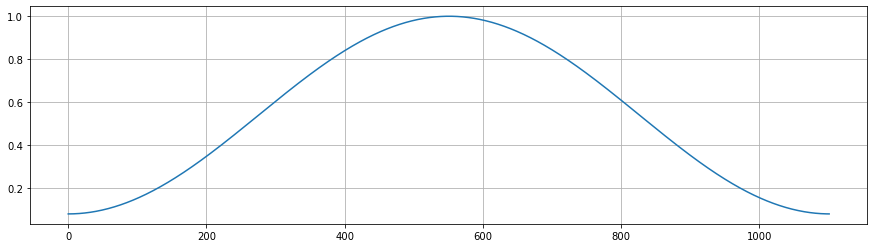

In [602]:
# fbanks = mel_filterbanks(512, n_filters = 20, max_freq = 22000, fs = 44000)
x = np.array([0] * 22050)
x = np.append(x, [1] * 11025)
x = np.append(x, [2] * 11025)

frame_width = 1102
stride = 441

window = hamming_window(frame_width)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

# mfcc(x)
filter_energies, frame_energies = mel_spectrogram(x,window_time = 0.25, stride_time = 0.1, fs = 44100)
print(frame_energies.shape)
# x_pad = reflect_pad(x, frame_width // 2)
# y_pad = np.pad(x, frame_width // 2, "reflect")
# frames = frame_audio(x_pad,frame_width,stride,fs)


# KNN Raw Implementation

This will be where I write my KNN implementation with code that will be easy to translate to C

In [606]:
def KNN(k, test_d, train_d, train_l):
    
    predicted_l = []
    dist_l = train_l.copy()

    for t_p in test_d:
        dist_l = train_l.copy()
        distance  = []

        # Find the distance of each point
        for tr_p in train_d:
            innersum = 0
            for i in range(train_d.shape[1]):
                 innersum += (t_p[i] - tr_p[i])**2
            distance.append( innersum**0.5 ) 
            
        # Sort Smallest to Largest Values
        for i in range(len(distance)):
            already_sorted = True

            for j in range(len(distance) - i - 1):
                if distance[j] > distance[j + 1]:
                    # If the item you're looking at is greater than its
                    # adjacent value, then swap them
                    distance[j], distance[j + 1] = distance[j + 1], distance[j]
                    dist_l[j], dist_l[j + 1] = dist_l[j + 1], dist_l[j]

                    already_sorted = False

            if already_sorted:
                break
                
        # Tally the votes using the labels previously saved
        vote = [0,0]
        vote[dist_l[0]] += 1
        vote[dist_l[1]] += 1
        vote[dist_l[2]] += 1
            
        if vote[0] > vote[1]:
            predicted_l.append(0)
        else:
            predicted_l.append(1)
        
    return predicted_l

In [607]:
# Test KNN function

pred = KNN(3, features_test, features_train, labels_train)

print("Predicted labels for the test set: ")
print(pred)
print("Expected labels for the test set: ")
print(labels_test)

Predicted labels for the test set: 
[1, 0, 0, 1, 1, 0, 0, 0]
Expected labels for the test set: 
[1 0 1 1 1 0 0 0]


# MEL Spectrum test

A emergency test to see if Mel Spectrum would work for pre-processing

In [611]:
# Mel spectrum test
mel_set = np.zeros((data.shape[0],10))
for i in range(data.shape[0]):
    __, frame_energies = mel_spectrogram(data[i],window_time = 0.25, stride_time = 0.1, fs = 44100)
    mel_set[i] = frame_energies

print(mel_set.shape)

(48, 10)


In [612]:
features_train, features_test, labels_train, labels_test = train_test_split(mel_set,labels,test_size=0.15)

print(features_train.dtype)

# Testing parameters to find the best set
params = {
    "n_neighbors" : list(range(3, 21, 2)),
    "weights" : ["uniform", "distance"],
    "metric" : ["euclidean", "manhattan", "chebyshev"]
}

GSCV = GridSearchCV(KNeighborsClassifier(), params, verbose=1, cv=3, n_jobs=-1)

float64


In [613]:
results = GSCV.fit(mel_set, labels)

print("The best parameters for KNN classification are: ")
print(results.best_params_)
print("\nWith a score of: " + str(results.best_score_))

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
The best parameters for KNN classification are: 
{'metric': 'chebyshev', 'n_neighbors': 3, 'weights': 'uniform'}

With a score of: 0.9583333333333334
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    4.5s finished


In [614]:
knn = KNeighborsClassifier(n_neighbors=3, metric="euclidean", weights="uniform")
knn = knn.fit(features_train,labels_train)

pred = knn.predict(features_test)

print("Predicted labels for the test set: ")
print(pred)
print("Expected labels for the test set: ")
print(labels_test)

Predicted labels for the test set: 
[0 0 1 1 0 0 1 0]
Expected labels for the test set: 
[0 0 1 1 0 1 1 0]


## Mel Spectrum Frame Energies

In an attempt to reduce time complexity, I will be using the frame energies of Mel Spectrum

In [592]:
# Export training data for DSP

f = open("out.txt", "w")

for data in features_train:
    for i in range(round(len(data)/2)):
        f.write(str(data[i]) + ", ")
    f.write("\n")
    for i in range(round(len(data)/2), len(data)):
        f.write(str(data[i]) + ", ")
    f.write("\n")

In [571]:
# Export training data for DSP

f = open("out.txt", "w")

for data in labels_train:
    f.write(str(data))
    f.write(",\n")